# `Setup`

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/alexanderries/aml_itu
MPS device found.


### `Config`

In [62]:
MODEL_NAME = 'TinyVGG_alex_w_augmentations'

# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `TinyVGG`

In [63]:
# IMG Transformations
augmentations = {
    'train': v2.Compose([
    v2.Resize(size=(168, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor()
    ]),
    'val+test': v2.Compose([
    T.Resize((168, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor()
    ])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [64]:
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=augmentations['val+test'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 15646
Lenght of val data: 3345
Lenght of val data: 3433


In [65]:
train_data.img_labels = train_data.img_labels
train_data.metadata.target.value_counts(True)

target
safe driving                    0.113511
talking on the phone - left     0.103924
texting - left                  0.103349
talking on the phone - right    0.102582
drinking                        0.102582
operating the radio             0.102263
texting - right                 0.101815
talking to passenger            0.092931
reaching behind                 0.092356
hair and makeup                 0.084686
Name: proportion, dtype: float64

In [66]:
val_data.img_labels = val_data.img_labels
val_data.img_labels.classname.value_counts(True)

classname
c0    0.110314
c3    0.107025
c6    0.102840
c9    0.101943
c4    0.100448
c2    0.100149
c5    0.100149
c1    0.098954
c8    0.092975
c7    0.085202
Name: proportion, dtype: float64

In [67]:
# Displaying training data including transformations
#train_data.display_classes(id_to_class=True)

In [68]:
# Displaying val data including transformations
#val_data.display_classes(id_to_class=True)

#### `Model`

In [69]:
# TinyVGG inpsired
# First Convolution Blocks With BatchNorm, MaxPool and Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_channesl, out_channls, kernel_size = (3, 3), stride=1, pool_kernel = (2,2), dropout_rate = .2):
        super(ConvBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channesl,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channls),
            nn.Conv2d(in_channels=out_channls,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channls),
            nn.MaxPool2d(kernel_size = pool_kernel),
            nn.Dropout(dropout_rate))
    
    def forward(self, x):
        return self.main(x)

# Added couple extra fully connected layers
class FullyConnected(nn.Module):
    def __init__(self, in_features, out_featuers, dropout_rate) -> None:
        super(FullyConnected, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_featuers),
            nn.ReLU(True),
            nn.BatchNorm1d(out_featuers),
            nn.Dropout(dropout_rate),)
    
    def forward(self, x):
        return self.main(x)
    
    
class TinyVGGish(torch.nn.Module):
    def __init__(self, 
                 filters = 32, 
                 num_classes = 10,
                 kernel_size = 3, 
                 stride = 1, 
                 in_channels = 3,
                 pool_kernel_size = 2,
                 dense_dropout_rate = .25,
                 conv_dropout_rate = .25):
        
        """TinyVGG Inspired Model with Added complexity and Regularizaiton"""
        super(TinyVGGish, self).__init__()
        
        # First Convolution Block
        self.main = nn.Sequential(
            ConvBlock(in_channesl=in_channels, out_channls=filters, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=conv_dropout_rate),
            ConvBlock(in_channesl=filters, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=conv_dropout_rate),
            ConvBlock(in_channesl=filters*2, out_channls=filters*4, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=conv_dropout_rate),
            nn.Flatten(),
            FullyConnected(in_features=52224, out_featuers=512, dropout_rate=dense_dropout_rate),
            FullyConnected(in_features=512, out_featuers=128, dropout_rate=dense_dropout_rate),
            FullyConnected(in_features=128, out_featuers=num_classes, dropout_rate=dense_dropout_rate),
            )

    def forward(self, x):
        # Pass the data through the convolutional blocks
        x = self.main(x)
        return x

In [70]:
# Initialize Efficientnet model
model = TinyVGGish(num_classes = 10)

In [71]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [72]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGish                               [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─ConvBlock: 2-1                    [32, 32, 82, 110]         --
│    │    └─Sequential: 3-1              [32, 32, 82, 110]         10,272
│    └─ConvBlock: 2-2                    [32, 64, 39, 53]          --
│    │    └─Sequential: 3-2              [32, 64, 39, 53]          55,680
│    └─ConvBlock: 2-3                    [32, 128, 17, 24]         --
│    │    └─Sequential: 3-3              [32, 128, 17, 24]         221,952
│    └─Flatten: 2-4                      [32, 52224]               --
│    └─FullyConnected: 2-5               [32, 512]                 --
│    │    └─Sequential: 3-4              [32, 512]                 26,740,224
│    └─FullyConnected: 2-6               [32, 128]                 --
│    │    └─Sequential: 3-5              [32, 128]              

#### `Training Methods`

In [73]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [74]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [75]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [76]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [77]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [78]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Set model to train mode and do pass over data
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        print(f"Epoch {epoch+1} of {epochs} - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")

        # lr Scheduler step
        #scheduler.step(val_loss)
        scheduler.step()

        

        # Print info
        
            
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, MODEL_NAME, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, MODEL_NAME, epoch)
            visualize_training(history, epoch+1)
            break
    
    return history

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.9901e-03.
Adjusting learning rate of group 0 to 9.9606e-03.
Adjusting learning rate of group 0 to 9.9114e-03.
Adjusting learning rate of group 0 to 9.8429e-03.
Adjusting learning rate of group 0 to 9.7553e-03.
Adjusting learning rate of group 0 to 9.6489e-03.
Adjusting learning rate of group 0 to 9.5241e-03.
Adjusting learning rate of group 0 to 9.3815e-03.
Adjusting learning rate of group 0 to 9.2216e-03.
Adjusting learning rate of group 0 to 9.0451e-03.
Adjusting learning rate of group 0 to 8.8526e-03.
Adjusting learning rate of group 0 to 8.6448e-03.
Adjusting learning rate of group 0 to 8.4227e-03.
Adjusting learning rate of group 0 to 8.1871e-03.
Adjusting learning rate of group 0 to 7.9389e-03.
Adjusting learning rate of group 0 to 7.6791e-03.
Adjusting learning rate of group 0 to 7.4088e-03.
Adjusting learning rate of group 0 to 7.1289e-03.
Adjusting learning rate of group 0 to 6.8406e-03.


/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


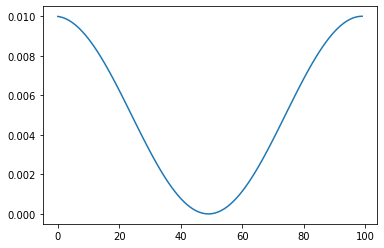

In [79]:
# Setting seed and general training setup
torch.manual_seed(seed)
epcohs = 50
learming_rate = 0.01
momentum = .9
weight_decay = 1e-5
# nestrov = True

# Creating Model Object
model = TinyVGGish(num_classes = 10, dense_dropout_rate=.5).to(device)

# Optimizer and and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=learming_rate, weight_decay=weight_decay, momentum=momentum)#,nesterov=nestrov)
# optimizer = torch.optim.Adam(model.parameters(), lr=learming_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max = epochs,  
                                                       eta_min = 0,
                                                       verbose=1)

# Visualizing scheduler effect on learning rate
lrs = []
for i in range(100):
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])
    
plt.plot(lrs)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Early stopping
early_stopping = EarlyStopper(patience=7, min_delta=.03)

##### `Training`


Epoch 1 of 50 started...
Epoch 1 of 50 - Train loss: 2.33335 - Train acc: 0.15365 - Val loss: 2.28814 - Val acc: 0.15812
Adjusting learning rate of group 0 to 9.9901e-03.
Saving model with new best val_loss: 2.28814

Epoch 2 of 50 started...
Epoch 2 of 50 - Train loss: 2.05095 - Train acc: 0.26940 - Val loss: 2.21628 - Val acc: 0.21950
Adjusting learning rate of group 0 to 9.9606e-03.
Saving model with new best val_loss: 2.21628

Epoch 3 of 50 started...
Epoch 3 of 50 - Train loss: 1.82900 - Train acc: 0.35211 - Val loss: 2.36870 - Val acc: 0.27691
Adjusting learning rate of group 0 to 9.9114e-03.
Early Stopping Counter 1 of 7

Epoch 4 of 50 started...
Epoch 4 of 50 - Train loss: 1.68219 - Train acc: 0.39997 - Val loss: 2.00535 - Val acc: 0.28792
Adjusting learning rate of group 0 to 9.8429e-03.
Saving model with new best val_loss: 2.00535
Early Stopping Counter Reset

Epoch 5 of 50 started...
Epoch 5 of 50 - Train loss: 1.52412 - Train acc: 0.44454 - Val loss: 2.12665 - Val acc: 0.26

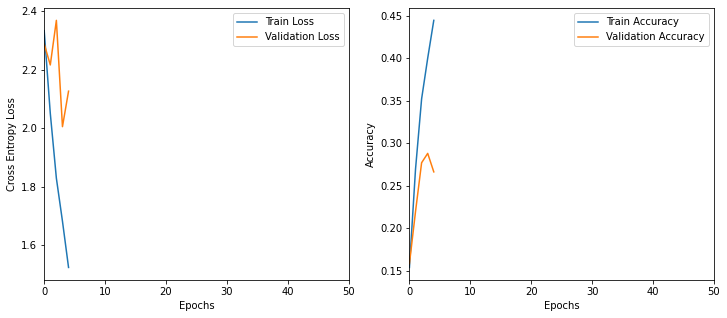

Early Stopping Counter 1 of 7

Epoch 6 of 50 started...
Epoch 6 of 50 - Train loss: 1.40609 - Train acc: 0.48203 - Val loss: 1.85199 - Val acc: 0.31642
Adjusting learning rate of group 0 to 9.6489e-03.
Saving model with new best val_loss: 1.85199
Early Stopping Counter Reset

Epoch 7 of 50 started...
Epoch 7 of 50 - Train loss: 1.35709 - Train acc: 0.48728 - Val loss: 1.90193 - Val acc: 0.32595
Adjusting learning rate of group 0 to 9.5241e-03.
Early Stopping Counter 1 of 7

Epoch 8 of 50 started...
Epoch 8 of 50 - Train loss: 1.37915 - Train acc: 0.48843 - Val loss: 1.98938 - Val acc: 0.27717
Adjusting learning rate of group 0 to 9.3815e-03.
Early Stopping Counter 2 of 7

Epoch 9 of 50 started...
Epoch 9 of 50 - Train loss: 1.26375 - Train acc: 0.51388 - Val loss: 1.90569 - Val acc: 0.34053
Adjusting learning rate of group 0 to 9.2216e-03.
Early Stopping Counter 3 of 7

Epoch 10 of 50 started...
Epoch 10 of 50 - Train loss: 1.21961 - Train acc: 0.52900 - Val loss: 1.89693 - Val acc: 0.

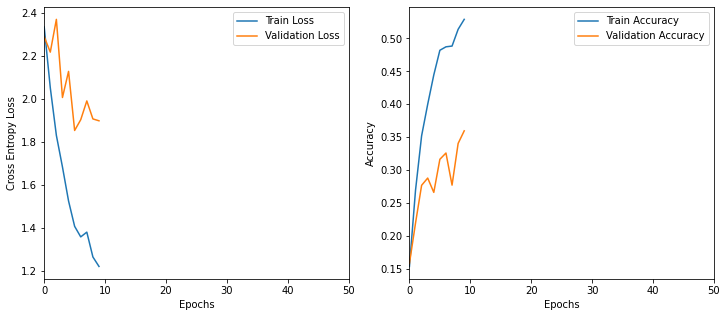

Early Stopping Counter 4 of 7

Epoch 11 of 50 started...
Epoch 11 of 50 - Train loss: 1.21623 - Train acc: 0.53298 - Val loss: 1.80351 - Val acc: 0.37736
Adjusting learning rate of group 0 to 8.8526e-03.
Saving model with new best val_loss: 1.80351
Early Stopping Counter Reset

Epoch 12 of 50 started...
Epoch 12 of 50 - Train loss: 1.18838 - Train acc: 0.53318 - Val loss: 1.81394 - Val acc: 0.40224
Adjusting learning rate of group 0 to 8.6448e-03.

Epoch 13 of 50 started...
Epoch 13 of 50 - Train loss: 1.15799 - Train acc: 0.53944 - Val loss: 1.82924 - Val acc: 0.37721
Adjusting learning rate of group 0 to 8.4227e-03.

Epoch 14 of 50 started...
Epoch 14 of 50 - Train loss: 1.13368 - Train acc: 0.54882 - Val loss: 1.82953 - Val acc: 0.38647
Adjusting learning rate of group 0 to 8.1871e-03.

Epoch 15 of 50 started...
Epoch 15 of 50 - Train loss: 1.13297 - Train acc: 0.54718 - Val loss: 1.85665 - Val acc: 0.37174
Adjusting learning rate of group 0 to 7.9389e-03.


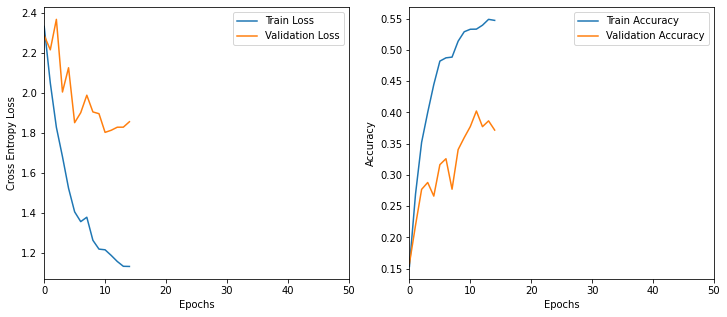

Early Stopping Counter 1 of 7

Epoch 16 of 50 started...
Epoch 16 of 50 - Train loss: 1.21979 - Train acc: 0.52351 - Val loss: 1.91176 - Val acc: 0.34268
Adjusting learning rate of group 0 to 7.6791e-03.
Early Stopping Counter 2 of 7

Epoch 17 of 50 started...
Epoch 17 of 50 - Train loss: 1.15648 - Train acc: 0.53918 - Val loss: 1.81797 - Val acc: 0.36322
Adjusting learning rate of group 0 to 7.4088e-03.

Epoch 18 of 50 started...
Epoch 18 of 50 - Train loss: 1.40681 - Train acc: 0.48369 - Val loss: 2.11616 - Val acc: 0.27684
Adjusting learning rate of group 0 to 7.1289e-03.
Early Stopping Counter 3 of 7

Epoch 19 of 50 started...
Epoch 19 of 50 - Train loss: 1.26075 - Train acc: 0.51501 - Val loss: 1.85520 - Val acc: 0.35581
Adjusting learning rate of group 0 to 6.8406e-03.
Early Stopping Counter 4 of 7

Epoch 20 of 50 started...
Epoch 20 of 50 - Train loss: 1.13686 - Train acc: 0.54783 - Val loss: 1.82262 - Val acc: 0.39109
Adjusting learning rate of group 0 to 6.5451e-03.


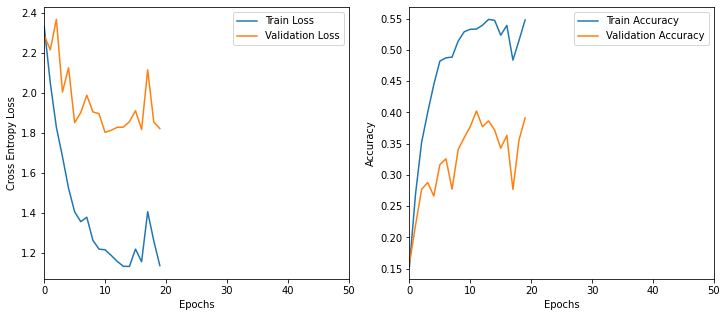


Epoch 21 of 50 started...
Epoch 21 of 50 - Train loss: 1.12766 - Train acc: 0.54185 - Val loss: 1.83375 - Val acc: 0.37502
Adjusting learning rate of group 0 to 6.2434e-03.
Early Stopping Counter 5 of 7

Epoch 22 of 50 started...
Epoch 22 of 50 - Train loss: 1.10337 - Train acc: 0.55478 - Val loss: 1.73704 - Val acc: 0.40650
Adjusting learning rate of group 0 to 5.9369e-03.
Saving model with new best val_loss: 1.73704
Early Stopping Counter Reset

Epoch 23 of 50 started...
Epoch 23 of 50 - Train loss: 1.07367 - Train acc: 0.56046 - Val loss: 1.75173 - Val acc: 0.40742
Adjusting learning rate of group 0 to 5.6267e-03.

Epoch 24 of 50 started...
Epoch 24 of 50 - Train loss: 1.06105 - Train acc: 0.56577 - Val loss: 1.71011 - Val acc: 0.39083
Adjusting learning rate of group 0 to 5.3140e-03.
Saving model with new best val_loss: 1.71011

Epoch 25 of 50 started...
Epoch 25 of 50 - Train loss: 1.05023 - Train acc: 0.56546 - Val loss: 1.65323 - Val acc: 0.45203
Adjusting learning rate of grou

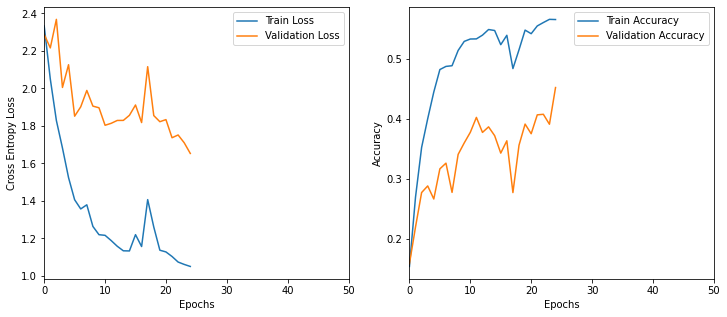


Epoch 26 of 50 started...
Epoch 26 of 50 - Train loss: 1.05687 - Train acc: 0.56302 - Val loss: 1.70920 - Val acc: 0.41542
Adjusting learning rate of group 0 to 4.6860e-03.
Early Stopping Counter 1 of 7

Epoch 27 of 50 started...
Epoch 27 of 50 - Train loss: 1.05073 - Train acc: 0.56936 - Val loss: 1.79018 - Val acc: 0.39361
Adjusting learning rate of group 0 to 4.3733e-03.
Early Stopping Counter 2 of 7

Epoch 28 of 50 started...
Epoch 28 of 50 - Train loss: 1.03993 - Train acc: 0.56425 - Val loss: 1.73142 - Val acc: 0.42022
Adjusting learning rate of group 0 to 4.0631e-03.
Early Stopping Counter 3 of 7

Epoch 29 of 50 started...
Epoch 29 of 50 - Train loss: 1.04576 - Train acc: 0.56519 - Val loss: 1.75589 - Val acc: 0.43487
Adjusting learning rate of group 0 to 3.7566e-03.
Early Stopping Counter 4 of 7

Epoch 30 of 50 started...
Epoch 30 of 50 - Train loss: 1.03844 - Train acc: 0.57221 - Val loss: 1.71654 - Val acc: 0.42218
Adjusting learning rate of group 0 to 3.4549e-03.


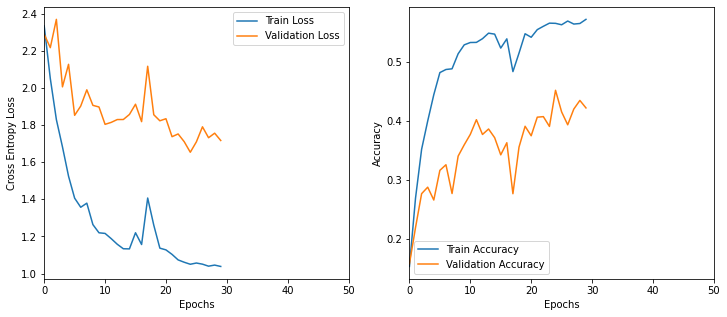

Early Stopping Counter 5 of 7

Epoch 31 of 50 started...
Epoch 31 of 50 - Train loss: 1.02561 - Train acc: 0.57019 - Val loss: 1.70423 - Val acc: 0.41728
Adjusting learning rate of group 0 to 3.1594e-03.
Early Stopping Counter 6 of 7

Epoch 32 of 50 started...
Epoch 32 of 50 - Train loss: 0.99925 - Train acc: 0.57906 - Val loss: 1.76020 - Val acc: 0.43260
Adjusting learning rate of group 0 to 2.8711e-03.
Early Stopping Counter 7 of 7
Epoch 32 of 50 - Early stopping
Saving final model, with loss:  1.7601992947714669


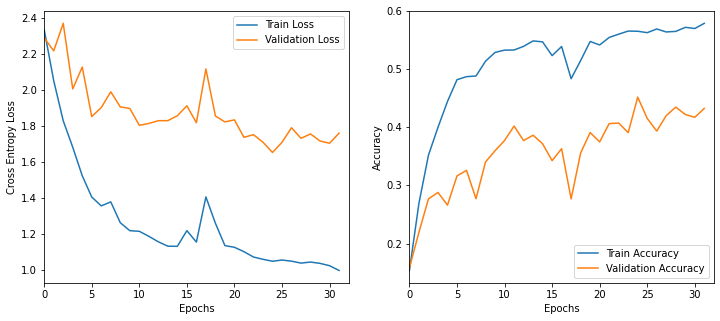

In [80]:
# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=scheduler,
                early_stopping=early_stopping)

### Testing on Test Images

In [81]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

test_imgs = os.listdir(config['dataset']['images']['test'])
test_img = test_imgs[random.randint(0, len(test_imgs))]

In [82]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [83]:
for i, data in enumerate(test_dataloader):
    imgs, labels = data
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Forward pass
    prediction = model(imgs)
    
    break

In [84]:
prediction.argmax(1)[0].item()

6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: reaching behind
True: talking on the phone - right


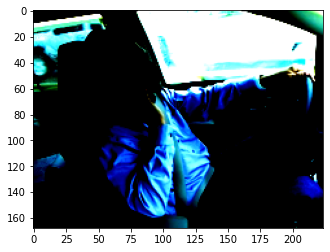

In [85]:
index = 16
print('Prediction:', config['dataset']['class_mapping']['c' + str(prediction.argmax(1)[index].item())])
print('True:', config['dataset']['class_mapping']['c' + str(labels[index].item())])

plt.imshow(imgs[index].cpu().permute(1, 2, 0))